In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../../datasets/famcs_students.csv')

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
N = 24
target_col = binary_cols[N % 8]  # ss
print(f"target_col = {target_col}")

predictors = ['bad_sleep', 'work_experience', 'social', 'sport', 'miss', 'study_form', 'score', 'retake']

df_processed = df.copy()
df_processed['bad_sleep'] = (df_processed['bad_sleep'] == 'Да').astype(int)
df_processed['study_form'] = (df_processed['study_form'] == 'Бюджет').astype(int)
df_processed['ss'] = (df_processed['ss'] == 'Да').astype(int)

experience_map = {'Не работаю': 0, 'Меньше года': 1, '1-2 года': 2, 'более 2 лет': 3}
df_processed['work_experience'] = df_processed['work_experience'].map(experience_map)

social_map = {'Интроверт': 0, 'Экстраверт': 1}
df_processed['social'] = df_processed['social'].map(social_map)

sport_map = {'Вообще нет': 0, 'Редко, легкая физкультура': 1, 'Да, я спортсмен': 2}
df_processed['sport'] = df_processed['sport'].map(sport_map)

sport_map = {'0': 0, '1': 1, '2+': 2}
df_processed['retake'] = df_processed['retake'].map(sport_map)

df_processed['miss'] = (df_processed['miss']).astype(int)
df_processed['score'] = (df_processed['score']).astype(float)

df_processed = df_processed.fillna(df_processed.median(numeric_only=True))

X = df_processed[predictors]
y = df_processed[target_col]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=4567
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=444
)

print(f"Размеры выборок: Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

target_col = ss
Размеры выборок: Train: (88, 8), Val: (20, 8), Test: (19, 8)


## 0. Тривиальный (Dummy) классификатор

Это "модель-заглушка", которая всегда предсказывает самый частый класс в тренировочных данных. Не использует никакой информации о признаках.

**Назначение:** Служит **базовым уровнем** для сравнения. Любая модель, имеющая практическое значение, должна превосходить его по качеству.

**Алгоритм реализации:**
1. **На этапе обучения:** вычислить, какой класс в $y_{train}$ встречается чаще. Сохранить этот класс.
2. **На этапе предсказания:** для любого объекта из тестовой или валидационной выборки вернуть этот сохраненный класс.

In [83]:
class DummyClassifier:
    def __init__(self):
        self.most_frequent_class = None
    
    def fit(self, X, y):
        self.most_frequent_class = y.mode()[0]
        return self
    
    def predict(self, X):
        return np.array([self.most_frequent_class] * len(X))

dummy_clf = DummyClassifier().fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

## 1. Наивный байесовский классификатор (Naive Bayes)

Основан на теореме Байеса и "наивном" предположении об **условной независимости** признаков.

**Формула (Теорема Байеса):**
$$
P(y | X) = \frac{P(y) \cdot P(X | y)}{P(X)}
$$
Где $X = (x_1, x_2, ..., x_n)$ - вектор признаков.

**"Наивное" предположение:**
$$
P(X | y) = P(x_1 | y) \cdot P(x_2 | y) \cdot ... \cdot P(x_n | y)
$$
Это упрощение позволяет оценивать вероятности для каждого признака отдельно.

**Классификация:** Объект $X$ относится к классу $y$, для которого апостериорная вероятность $P(y | X)$ максимальна.

**Алгоритм реализации (для дискретных признаков):**

**Обучение:**
- Оценить **априорные вероятности** классов:
  $$
  P(y=c) = \frac{\text{Количество объектов класса c в train}}{\text{Общее количество объектов в train}}
  $$
- Для каждого признака $x_i$ и каждого класса $y=c$ оценить **условные вероятности** (с добавлением сглаживания Лапласа):
  $$
  P(x_i = v | y=c) = \frac{\text{Количество объектов класса c, у которых } x_i=v \ + \ \alpha}{\text{Общее количество объектов класса c} \ + \ \alpha \cdot V_i}
  $$
  где:
  - $v$ - конкретное значение признака $x_i$
  - $V_i$ - количество уникальных значений признака $x_i$
  - $\alpha$ (обычно 1) - параметр сглаживания

**Предсказание:**
- Для объекта $X = (x_1, x_2, ..., x_n)$ вычислить **score** (логарифм числителя в первой формуле) для каждого класса:
  $$
  \text{score}(y=c) = \log(P(y=c)) + \sum_{i=1}^{n} \log(P(x_i | y=c))
  $$
  (Использование логарифмов предотвращает численное исчезновение при умножении малых вероятностей).
- Класс с наибольшим **score** становится предсказанием.

In [84]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.class_priors = None
        self.feature_probs = None
        self.classes = None
        self.feature_values = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_features = X.shape[1]
        
        self.class_priors = {}
        for c in self.classes:
            self.class_priors[c] = np.sum(y == c) / len(y)
        
        self.feature_probs = {}
        self.feature_values = {}
        
        for feature_idx in range(n_features):
            unique_vals = np.unique(X.iloc[:, feature_idx])
            self.feature_values[feature_idx] = unique_vals
            
            for c in self.classes:
                X_c = X[y == c]
                
                probs = {}
                for val in unique_vals:
                    count = np.sum(X_c.iloc[:, feature_idx] == val) + self.alpha
                    total = len(X_c) + self.alpha * len(unique_vals)
                    probs[val] = count / total
                
                key = (feature_idx, c)
                self.feature_probs[key] = probs
        
        return self
    
    def predict(self, X):
        predictions = []
        
        for i in range(len(X)):
            best_class = None
            best_score = -np.inf
            
            for c in self.classes:
                score = np.log(self.class_priors[c])
                
                for feature_idx in range(X.shape[1]):
                    feature_val = X.iloc[i, feature_idx]
                    key = (feature_idx, c)
                    
                    if feature_val in self.feature_probs[key]:
                        prob = self.feature_probs[key][feature_val]
                    else:
                        unique_vals = self.feature_values[feature_idx]
                        prob = self.alpha / (len(X) + self.alpha * len(unique_vals))
                    
                    score += np.log(prob)
                
                if score > best_score:
                    best_score = score
                    best_class = c
            
            predictions.append(best_class)
        
        return np.array(predictions)

nb_clf = NaiveBayesClassifier(alpha=1).fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)

## 2. Метод k-ближайших соседей (k-NN)

**Теория:** Объект классифицируется большинством голосов его $k$ ближайших соседей в пространстве признаков.

**Гиперпараметр $k$:** Количество соседей. Подбирается на валидационной выборке.
- Слишком маленькое $k$ → модель шумная и неустойчивая (переобучение)
- Слишком большое $k$ → модель слишком сглаженная (недообучение)

**Алгоритм реализации:**

**Обучение:** По сути, это запоминание тренировочного датасета.

**Предсказание:**
1. Для нового объекта вычислить расстояния до всех объектов в тренировочной выборке
2. Выбрать $k$ объектов с наименьшими расстояниями
3. Найти преобладающий класс среди этих $k$ соседей

In [85]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X.values
        self.y_train = y.values
        return self
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict(self, X):
        predictions = []
        
        for _, x_test in X.iterrows():
            distances = []
            
            for i, x_train in enumerate(self.X_train):
                dist = self._euclidean_distance(x_test.values, x_train)
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            
            votes = {}
            for _, label in k_nearest:
                votes[label] = votes.get(label, 0) + 1
            
            predicted_class = max(votes.items(), key=lambda x: x[1])[0]
            predictions.append(predicted_class)
        
        return np.array(predictions)

# Подбор оптимального k на валидационной выборке
best_k = 1
best_f1 = 0

for k in range(1, 16):
    knn_clf = KNNClassifier(k=k).fit(X_train, y_train)
    y_pred_knn_val = knn_clf.predict(X_val)
    
    cm = confusion_matrix(y_val, y_pred_knn_val)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Оптимальное k: {best_k} с F1-score: {best_f1:.4f}")

knn_clf = KNNClassifier(k=best_k).fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

Оптимальное k: 1 с F1-score: 0.0000


## 3. Логистическая регрессия (Logistic Regression)

**Теория:** Это линейный классификатор, который прогнозирует вероятность принадлежности объекта к определённому классу. Для этого она использует линейную комбинацию входных признаков, которую затем пропускает через логистическую (сигмоидальную) функцию, преобразующую результат в вероятность

**Формула (Логистическая функция):**
$$
P(y=1 | X) = \sigma(z) = \frac{1}{1 + e^{-z}}
$$
где $z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$ - линейная комбинация признаков (логит).

**Обучение:** Нахождение весов $w$, которые максимизируют **функцию правдоподобия**. Реализуется методами градиентного спуска.

**Порог классификации (Threshold):** По умолчанию 0.5. Если $P(y=1 | X) >= 0.5$, то делается вывод о принадлежности к классу 1, иначе 0. Этот порог можно менять, чтобы управлять соотношением между Precision и Recall.

**Алгоритм реализации:**

**Обучение (Градиентный спуск):**
* Обычно используется метод максимального правдоподобия, согласно которому выбираются параметры 
θ, максимизирующие значение функции правдоподобия на обучающей выборке.
* Для максимизации этой функции может быть применён, например, метод градиентного спуска.

**Предсказание вероятностей:** Рассчитать $P(y=1 | X)$

**Выбор порога:**
1. Для каждого возможного порога $t$ на валидационной выборке:
   - Сделать жесткие предсказания: если вероятность >= t, то класс 1, иначе 0
   - Вычислить Precision и Recall для этих предсказаний
   - Вычислить F1-score: $F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$
2. Выбрать порог $t$, при котором **F1-score на валидационной выборке максимален**

Оптимальный порог: 0.180 с F1-score: 0.4000


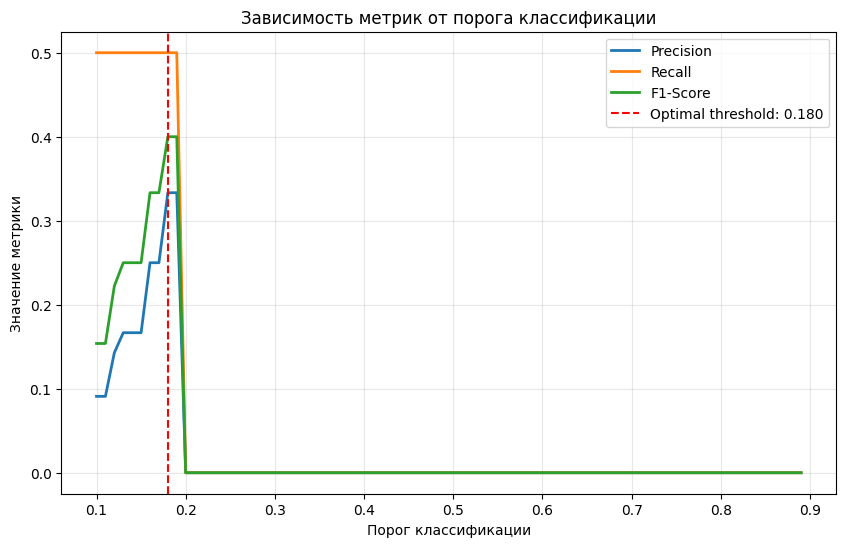

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class LogisticRegressionNoBias:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        
        # Градиентный спуск
        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights)
            y_pred = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            
            self.weights -= self.learning_rate * dw
        
        return self
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights)
        return self._sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

lr_clf_nobias = LogisticRegressionNoBias(learning_rate=0.1, n_iter=3000).fit(X_train.values, y_train.values)

y_proba_lr_val = lr_clf_nobias.predict_proba(X_val.values)

# Подбор порога классификации по максимуму F1
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0
precision_list = []
recall_list = []
f1_list = []

for threshold in thresholds:
    y_pred_val = (y_proba_lr_val >= threshold).astype(int)
    
    cm = confusion_matrix(y_val, y_pred_val)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Оптимальный порог: {best_threshold:.3f} с F1-score: {best_f1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision', linewidth=2)
plt.plot(thresholds, recall_list, label='Recall', linewidth=2)
plt.plot(thresholds, f1_list, label='F1-Score', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Optimal threshold: {best_threshold:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от порога классификации')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

y_proba_lr = lr_clf_nobias.predict_proba(X_test.values)
y_pred_lr = (y_proba_lr >= best_threshold).astype(int)

## 3. Метрики качества классификации

Все метрики вычисляются путем сравнения истинных меток ($y_{true}$) и предсказанных меток ($y_{pred}$).

### Матрица ошибок (Confusion Matrix)
- **TP (True Positive):** Объекты класса 1, корректно предсказанные как 1
- **FP (False Positive):** Объекты класса 0, ошибочно предсказанные как 1
- **FN (False Negative):** Объекты класса 1, ошибочно предсказанные как 0
- **TN (True Negative):** Объекты класса 0, корректно предсказанные как 0

### Accuracy (Точность)
Доля правильных ответов.
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$
Может быть неинформативна при несбалансированных классах.

### Precision (Точность)
Качество предсказаний "положительного" класса.
$$
\text{Precision} = \frac{TP}{TP + FP}
$$
"Насколько мы можем доверять, что объект, который модель назвала положительным, действительно является положительным?"

### Recall (Полнота)
Способность модели находить все положительные объекты.
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
"Какую долю всех реально положительных объектов наша модель смогла обнаружить?"

### F1-Score
Гармоническое среднее между Precision и Recall. Учитывает обе ошибки (FP и FN).
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### ROC-AUC (Area Under the ROC Curve)
- **ROC-кривая** строится в осях **True Positive Rate (TPR, она же Recall)** и **False Positive Rate (FPR)**
  $$
  FPR = \frac{FP}{FP + TN}
  $$
- Кривая показывает, как меняется пара (TPR, FPR) при изменении порога классификации от 0 до 1
- **AUC (Area Under Curve)** - площадь под ROC-кривой. Интерпретируется как вероятность того, что случайно выбранный положительный объект будет иметь оценку (вероятность) выше, чем у случайно выбранного отрицательного объекта
- **Значение:** AUC = 0.5 - качество как у случайного угадывания, AUC = 1.0 - идеальное разделение


Тривиальный классификатор
Accuracy:  0.8947
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000


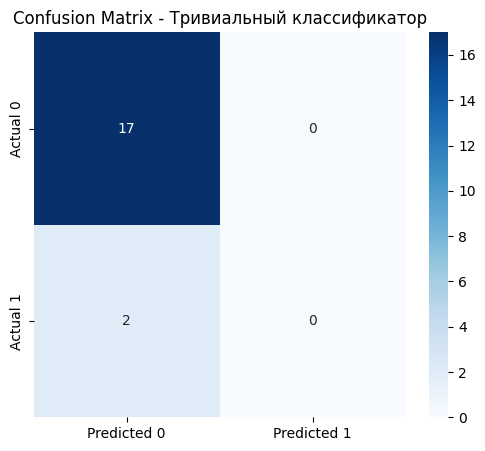


Наивный Байес
Accuracy:  0.8421
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000


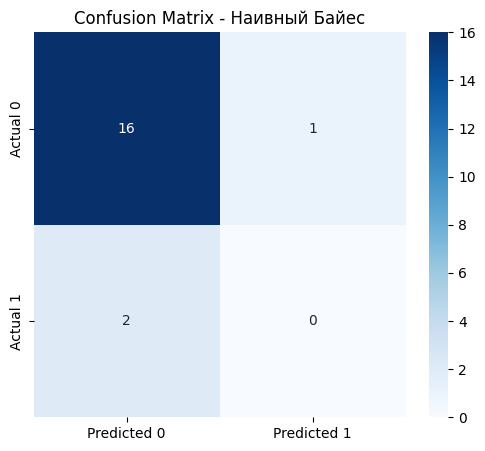


K-ближайших соседей
Accuracy:  0.7895
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000


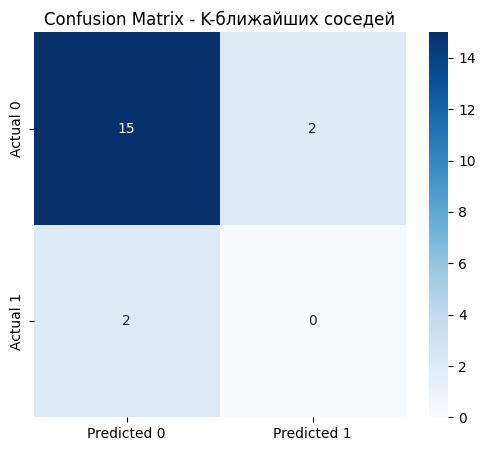


Логистическая регрессия
Accuracy:  0.6316
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.3529


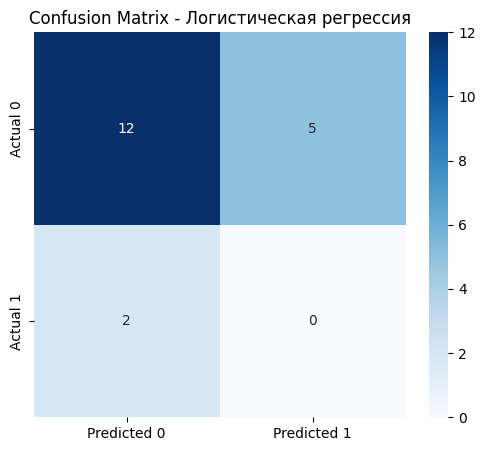


Сравнительная таблица моделей:
                     accuracy  precision  recall   f1  roc_auc
Dummy                  0.8947        0.0     0.0  0.0      NaN
Naive Bayes            0.8421        0.0     0.0  0.0      NaN
K-NN                   0.7895        0.0     0.0  0.0      NaN
Logistic Regression    0.6316        0.0     0.0  0.0   0.3529


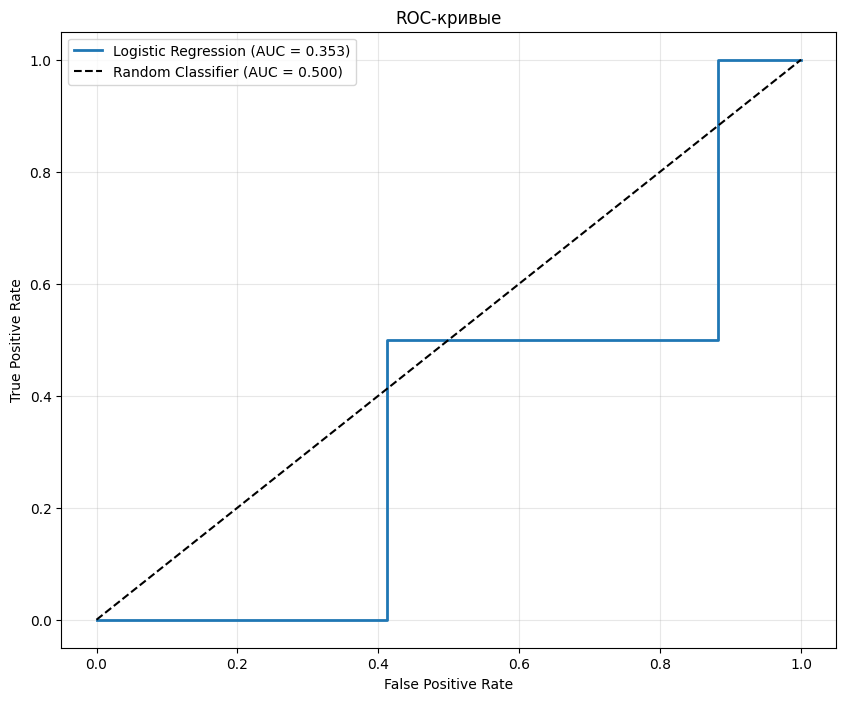

In [87]:
def evaluate_model(y_true, y_pred, y_proba=None, model_name=""):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    roc_auc = None
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n{model_name}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    
    plt.figure(figsize=(6, 5))
    sns.heatmap([[tn, fp], [fn, tp]], 
                annot=True, fmt='d', 
                cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

results = {}

results['Dummy'] = evaluate_model(y_test, y_pred_dummy, model_name="Тривиальный классификатор")
results['Naive Bayes'] = evaluate_model(y_test, y_pred_nb, model_name="Наивный Байес")
results['K-NN'] = evaluate_model(y_test, y_pred_knn, model_name="K-ближайших соседей")
results['Logistic Regression'] = evaluate_model(y_test, y_pred_lr, y_proba_lr, model_name="Логистическая регрессия")

comparison_df = pd.DataFrame(results).T
print("\nСравнительная таблица моделей:")
print(comparison_df.round(4))

plt.figure(figsize=(10, 8))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()